In [2]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    'mssql+pyodbc://localhost/Project1?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes'
)
hdf = pd.read_sql('SELECT * FROM machine_prop', engine)
print(hdf.head())


   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [4]:
# Drop columns not needed for ML
hdf = hdf.drop(['UDI', 'Product ID' , 'Machine failure', 'TWF', 'PWF', 'OSF', 'RNF'], axis=1)

# Encode 'Type' as dummies
hdf = pd.get_dummies(hdf, columns=['Type'])

# Check for missing values
print(hdf.isnull().sum())
hdf = hdf.dropna()  # Or use imputation

# (Optional) Explore data, correlations, etc.


Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
HDF                        0
Type_H                     0
Type_L                     0
Type_M                     0
dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
h_x = hdf.drop(['HDF'],axis = 1)
h_y = hdf['HDF']
hx_train, hx_test, hy_train, hy_test = train_test_split(
    h_x, h_y, stratify=h_y, test_size=0.2, random_state=42
)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

hclf = RandomForestClassifier(n_estimators=100, random_state=42)
hclf.fit(hx_train, hy_train)

hy_pred = hclf.predict(hx_test)
print(classification_report(hy_test, hy_pred))
print(confusion_matrix(hy_test, hy_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1977
           1       1.00      0.57      0.72        23

    accuracy                           0.99      2000
   macro avg       1.00      0.78      0.86      2000
weighted avg       1.00      0.99      0.99      2000

[[1977    0]
 [  10   13]]


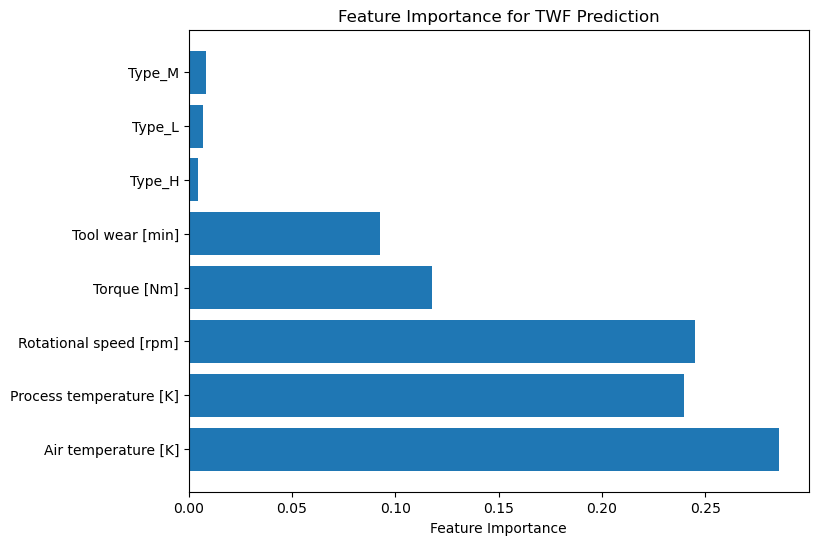

In [10]:
import matplotlib.pyplot as plt

feature_names = hx_train.columns
importances = hclf.feature_importances_

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for TWF Prediction")
plt.show()
